In [16]:
import ot
import numpy as np
import matplotlib.pyplot as plt

s = 0.04
n = 40000

In [17]:
def proba_rejet(u,v,W,x,y,Z,T):
    u,v,W=histogramme(u),histogramme(v),histogramme(W)
    x,y,Z=histogramme(x),histogramme(y),histogramme(Z)
    return 1/(2*s**2)*(np.linalg.norm(T-ot.emd(u,v,W))**2-np.linalg.norm(T-ot.emd(x,y,Z))**2)

def in_hypercube(u,v,W):

    if any(x < 0 or x > 1 for x in u):
        return False

    if any(x < 0 or x > 1 for x in v):
        return False

    if any(any(x < 0 or x > 1 for x in row) for row in W):
        return False
    return True

def histogramme(x):
    # Normaliser la liste pour que la somme soit égale à 1
    somme = np.sum(x)
    histogramme = x / somme
    return histogramme

def MH_gibbs(T):
    N = len(T)
    # Initialisation
    U, V, C = np.zeros((n, N)), np.zeros((n, N)), np.zeros((n, N, N))
    U[0] = np.random.uniform(size=N)
    V[0] = np.random.uniform(size=N)
    C[0, :, :] = np.random.uniform(size=(N, N))
    def fix_coord(x):
        for i in range(N): x[i,i]=10
        return x
    # Vecteurs aléatoires
    e_u, e_v,e_C  = np.random.normal(0, 0.01, (N, n)), np.random.normal(0, 0.01, (N, n)), np.random.normal(0, 0.01, (N, N, n))
    u_u, u_v, u_c  = np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n)), np.log(np.random.uniform(size=n))

    acceptance_rate_u = 0
    acceptance_rate_v=0
    acceptance_rate_C=0

    running_average_U = [U[0]]
    running_average_V = [V[0]]
    running_average_C = [C[0]]

    for k in range(n-1):
        # Pas pour U
        x, y, Z = U[k] + e_u[:, k], V[k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        else:
            if u_u[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_u += 1
            else: U[k+1], V[k+1], C[k+1] = U[k], V[k], C[k]
        UK=U[k+1]
        # Pas pour V
        x, y, Z = UK, V[k] + e_v[:, k], C[k]
        if not in_hypercube(x, y, Z): U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        else:
            if u_v[k] < proba_rejet(UK, V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_v += 1
            else: U[k+1], V[k+1], C[k+1] = UK, V[k], C[k]
        VK=V[k+1]
        # Pas pour C
        x, y, Z = UK, VK, C[k] + e_C[:, :, k]
        if not in_hypercube(x, y, Z):
            U[k+1], V[k+1], C[k+1] = UK, VK, C[k]
        else:
            if u_c[k] < proba_rejet(U[k], V[k], C[k], x, y, Z,T):
                U[k+1], V[k+1], C[k+1] = x, y, Z
                acceptance_rate_C += 1
            else: U[k+1], V[k+1], C[k+1] = UK, VK, C[k]

        # Calcul du running average
        running_average_U.append((U[k+1]+U[k])*(k/(k+1)))
        running_average_V.append((V[k+1]+V[k])*(k/(k+1)))
        running_average_C.append((C[k+1]+C[k])*(k/(k+1)))

    acceptance_rate_u /= n
    acceptance_rate_v /= n
    acceptance_rate_C /= n
    return U, V, C, acceptance_rate_u,acceptance_rate_v,acceptance_rate_C, running_average_U,running_average_V,running_average_C

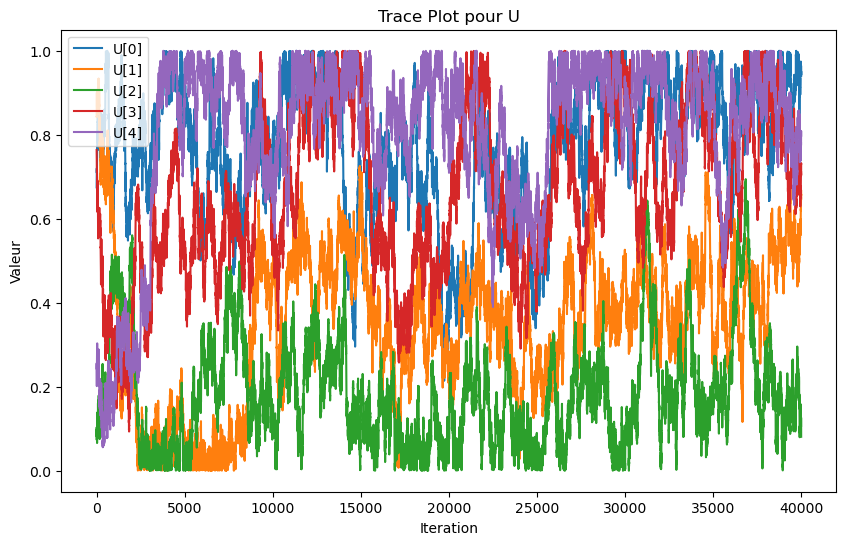

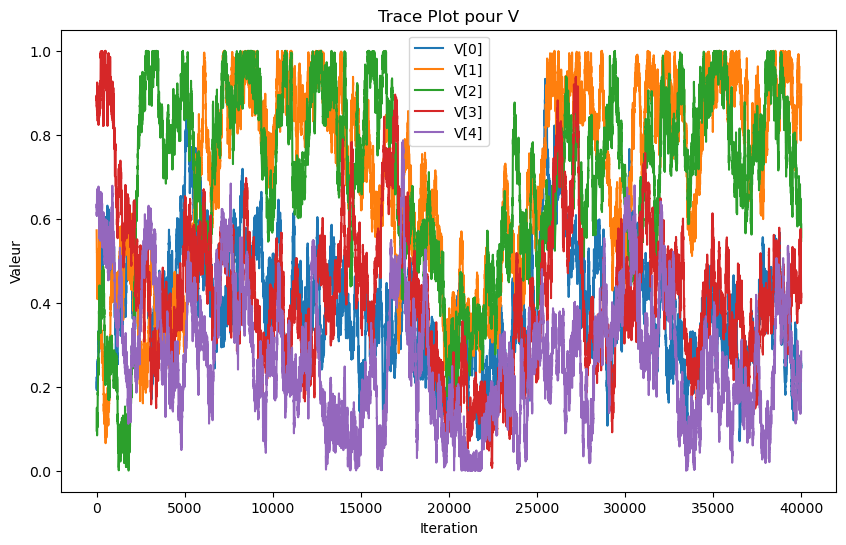

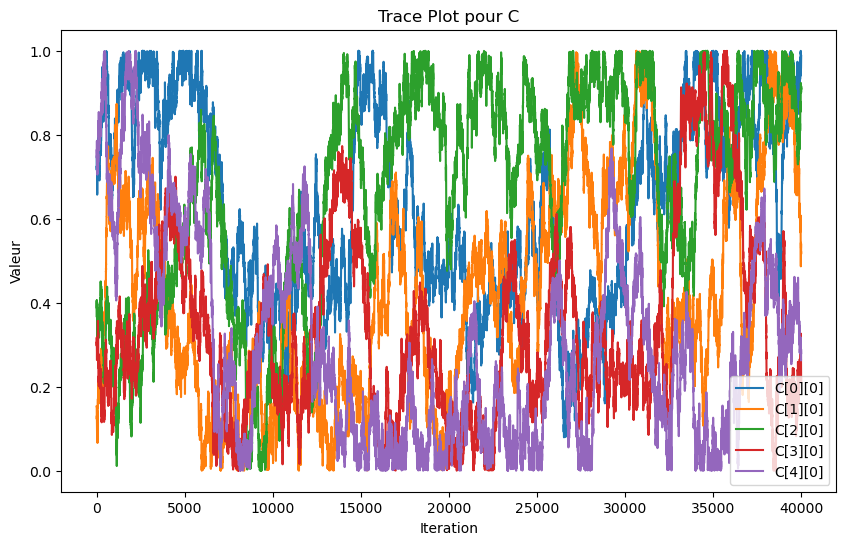

Taux d'acceptation pour U : 0.863525
Taux d'acceptation pour V : 0.875725
Taux d'acceptation pour C : 0.67255


In [18]:
np.random.seed(123)

u = np.random.random(5)
v = np.random.random(5)
W = np.random.uniform(size=(5, 5))

u, v, W = histogramme(u), histogramme(v), histogramme(W)

T = ot.emd(u, v, W) + np.random.randn(5, 5) * s

# Simulation
U, V, C, acceptance_rate_u, acceptance_rate_v, acceptance_rate_C, running_average_U, running_average_V, running_average_C = MH_gibbs(T)

# Trace plot pour U
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(U[:, i], label=f"U[{i}]")
plt.title("Trace Plot pour U")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

# Trace plot pour V
plt.figure(figsize=(10, 6))
for i in range(len(U[0])):
    plt.plot(V[:, i], label=f"V[{i}]")
plt.title("Trace Plot pour V")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(len(C[0])):
    plt.plot(C[:, i, 0], label=f"C[{i}][{0}]")
plt.title("Trace Plot pour C")
plt.xlabel("Iteration")
plt.ylabel("Valeur")
plt.legend()
plt.show()


print(f"Taux d'acceptation pour U : {acceptance_rate_u}")
print(f"Taux d'acceptation pour V : {acceptance_rate_v}")
print(f"Taux d'acceptation pour C : {acceptance_rate_C}")

In [21]:
print(u, running_average_U[-1]/np.sum(running_average_U[-1]))

[0.28080675 0.11536743 0.09146337 0.2222825  0.29007995] [0.29295161 0.2046425  0.02769373 0.22663021 0.24808194]


In [22]:
print(v, running_average_V[-1]/np.sum(running_average_V[-1]))

[0.14285692 0.3311435  0.23122471 0.162381   0.13239387] [0.10397232 0.37839575 0.22950756 0.17287279 0.11525158]


In [23]:
print(W)

[[0.03014702 0.06404454 0.03852708 0.0052425  0.03496683]
 [0.06483039 0.01603128 0.01541284 0.04669498 0.04671924]
 [0.05572997 0.07461969 0.06364094 0.05367634 0.06346419]
 [0.02837084 0.0317819  0.02005215 0.02580178 0.05542911]
 [0.00809111 0.03809917 0.03784983 0.04336856 0.03740774]]


In [24]:
print(running_average_C[-1]/np.sum(running_average_C[-1]))

[[0.09034536 0.06039351 0.05093999 0.01667294 0.01766551]
 [0.04755483 0.01141389 0.02738912 0.03127514 0.05458579]
 [0.08351714 0.01589756 0.07207694 0.01661323 0.0304019 ]
 [0.02028928 0.08754622 0.00442573 0.06541373 0.01080098]
 [0.02561581 0.03591569 0.08874894 0.00171272 0.03278806]]
